In [1]:
import numpy as np
import pandas as pd

In [30]:
model_name = 'TED_ZK3_zh'
#model_name = 'ZK3_zh'

# Read sentence for each article csv file.

In [3]:
df_train_transcript = pd.read_csv('./CORPUS/MERGE/TRAIN_ALL.csv')
df_train_transcript = df_train_transcript.to_dict(orient='dict')
TRAIN_ESENT = (list(df_train_transcript['EN'].values()))
TRAIN_KSENT = (list(df_train_transcript['KO'].values()))
TRAIN_ZSENT = (list(df_train_transcript['ZH-TW'].values()))
df_train_transcript = []

In [4]:
df_test_transcript = pd.read_csv('./CORPUS/MERGE/TEST_ALL.csv')
df_test_transcript = df_test_transcript.to_dict(orient='dict')
TEST_ESENT = (list(df_test_transcript['EN'].values()))
TEST_KSENT = (list(df_test_transcript['KO'].values()))
TEST_ZSENT = (list(df_test_transcript['ZH-TW'].values()))
df_test_transcript = []

In [ ]:
## ted2020 dataset

In [28]:
df_train_transcript = pd.read_csv('./CORPUS/ted2020/TED2020_HANJA_TRAIN_ALL.csv')
df_train_transcript = df_train_transcript.to_dict(orient='dict')

TRAIN_KSENT = (list(df_train_transcript['KO'].values()))

TRAIN_ZSENT = (list(df_train_transcript['ZH'].values()))

TRAIN_HSENT = (list(df_train_transcript['HANJA_Z'].values()))

print(len(TRAIN_KSENT))
df_train_transcript = []

311376


In [29]:
df_test_transcript = pd.read_csv('./CORPUS/ted2020/TED2020_HANJA_TEST_ALL.csv')
df_test_transcript = df_test_transcript.to_dict(orient='dict')

TEST_KSENT = (list(df_test_transcript['KO'].values()))
TEST_ZSENT = (list(df_test_transcript['ZH'].values()))
TEST_HSENT = (list(df_test_transcript['HANJA_Z'].values()))
#TEST_HSENT = (list(df_test_transcript['HANJA_K'].values()))

df_test_transcript = []
print(len(TEST_KSENT))

77844


# Pretrain Model

In [5]:
import torch
from transformers import BertTokenizer, BertModel, BertConfig, BertForPreTraining, AutoModel, BertTokenizerFast
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertForMaskedLM
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

In [6]:
# 設定訓練參數
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_length = 64
batch_size = 16
#batch_size = 32
learning_rate = 1e-4
num_epochs = 10

In [6]:
# 加載預訓練的BERT模型和分詞器
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
#bert_model = BertModel.from_pretrained('bert-base-multilingual-cased').to(device)

In [7]:
zh_tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
zh_bert_model = AutoModel.from_pretrained('ckiplab/bert-base-chinese')

Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
ko_tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
ko_bert_model = BertModel.from_pretrained("kykim/bert-kor-base")

In [9]:
my_src_tokenizer = zh_tokenizer
my_tokenizer = zh_tokenizer
my_tgt_tokenizer = ko_tokenizer
tgt_tokenizer = ko_tokenizer

In [10]:
# 假設您有一個平行語料庫，這是您的資料集
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences
        self.length = len(source_sentences)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        source = self.source_sentences[index]
        target = self.target_sentences[index]
        return source, target


In [11]:
# 建立模型
class TranslationModel(nn.Module):
    global my_tgt_tokenizer
    def __init__(self, bert_model):
        super(TranslationModel, self).__init__()
        self.bert = bert_model
        self.linear = nn.Linear(self.bert.config.hidden_size, my_tgt_tokenizer.vocab_size)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        prediction_scores = self.linear(outputs.last_hidden_state)
        return prediction_scores


In [12]:
# 載入資料集
train_source_sentences = TRAIN_ZSENT  # 中文句子
train_target_sentences = TRAIN_KSENT  # 韓文句子
dataset = TranslationDataset(train_source_sentences, train_target_sentences)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [13]:
test_source_sentences = TEST_ZSENT  # 中文句子
test_target_sentences = TEST_KSENT  # 韓文句子
test_dataset = TranslationDataset(test_source_sentences, test_target_sentences)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [14]:
# 初始化模型、損失函數和優化器
model = TranslationModel(zh_bert_model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# 加載訓練好的模型
model = TranslationModel(zh_bert_model).to(device)
model.load_state_dict(torch.load('./MODELS/best_translation_model({}).pth'.format(model_name)))

<All keys matched successfully>

In [16]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time%60)
  return elapsed_mins, elapsed_secs

In [17]:
!pip install tqdm

In [17]:
from tqdm import tqdm

In [17]:
def train(path):
    global model, dataloader, optimizer, criterion, my_src_tokenizer, my_tgt_tokenizer
    model.train()
    total_loss = 0
    with tqdm(total = len(dataloader)) as pbar:
      for batch in dataloader:
        source_batch, target_batch = batch
        source_tokens = my_src_tokenizer(source_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        target_tokens = my_tgt_tokenizer(target_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)

        optimizer.zero_grad()
        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
        loss = criterion(output.transpose(1, 2), target_tokens.input_ids)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.update(1)
    torch.save(model.state_dict(), path)

    return total_loss#/len(dataloader)

In [18]:
def evaluate():
  global model, test_dataloader, criterion, my_src_tokenizer, my_tgt_tokenizer
  model.eval()
  total_loss = 0
  with torch.no_grad():
    with tqdm(total = len(test_dataloader)) as pbar:
      for batch in test_dataloader:
        source_batch, target_batch = batch
        source_tokens = my_src_tokenizer(source_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        target_tokens = my_tgt_tokenizer(target_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)

        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
        loss = criterion(output.transpose(1, 2), target_tokens.input_ids)

        total_loss += loss.item()
        pbar.update(1)

  return total_loss#/len(test_dataloader)

In [19]:
def loss_history(train_loss_values, test_loss_values, path='', to_show=False):
  before_train_loss = []
  before_test_loss = []
  try:
    df_loss = pd.read_csv('./MODELS/LOSS_HISTORY/loss_plot_{}.csv'.format(path))
    df_loss.to_dict(orient='dict')

    try:
      before_train_loss = list(df_loss['TRAIN_LOSS'].values())
      before_test_loss = list(df_loss['TEST_LOSS'].values())
    except:
      before_train_loss = list(df_loss['TRAIN_LOSS'])
      before_test_loss = list(df_loss['TEST_LOSS'])


  except:
    before_train_loss = []
    before_test_loss = []

  if(len(before_train_loss)>0):
    train_loss_values = before_train_loss + train_loss_values
    test_loss_values = before_test_loss + test_loss_values

  # 假設您有每個 epoch 的索引
  epochs = range(1, len(train_loss_values) + 1)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  plt.plot(epochs, train_loss_values, 'b', label='Training loss')
  plt.plot(epochs, test_loss_values, 'r', label='Test loss')
  plt.title('Training and Test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # 儲存折線圖
  plt.savefig('./MODELS/LOSS_HISTORY/loss_plot_{}.png'.format(path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame({'TRAIN_LOSS':train_loss_values,'TEST_LOSS':test_loss_values})
  df_loss.to_csv('./MODELS/LOSS_HISTORY/loss_plot_{}.csv'.format(path),index=False)

In [20]:
def bleu_history(bleu_score_values, path='', to_show=False):
  before_bleu_score = []
  try:
    df_loss = pd.read_csv('./MODELS/LOSS_HISTORY/blue_plot_{}.csv'.format(path))
    df_loss.to_dict(orient='dict')

    try:
      before_bleu_score = list(df_loss['BLEU_SCORE'].values())
    except:
      before_bleu_score = list(df_loss['BLEU_SCORE'])


  except:
    before_bleu_score = []

  if(len(before_bleu_score)>0):
    bleu_score_values = before_bleu_score + bleu_score_values

  # 假設您有每個 epoch 的索引
  epochs = range(1, len(bleu_score_values) + 1)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  plt.plot(epochs, bleu_score_values, 'b', label='BLEU score')
  plt.title('BLEU SCORE')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()

  # 儲存折線圖
  plt.savefig('./MODELS/LOSS_HISTORY/blue_plot_{}.png'.format(path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame({'BLEU_SCORE':bleu_score_values})
  df_loss.to_csv('./MODELS/LOSS_HISTORY/blue_plot_{}.csv'.format(path),index=False)

In [21]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

def bleu_score(test_source_sentences,model,max_length,device):
  model.eval()
  global my_src_tokenizer, my_tgt_tokenizer
  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(test_source_sentences)) as pbar:
    for source_sentence in test_source_sentences:
      source_tokens = my_src_tokenizer(source_sentence, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
      with torch.no_grad():
        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
      generated_sentence = my_tgt_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
      generated_sentences.append(generated_sentence)
      pbar.update(1)


  # 計算 BLEU 分數
  smoothie = SmoothingFunction().method4
  bleu_score = corpus_bleu([[ref] for ref in test_target_sentences], generated_sentences, smoothing_function=smoothie)

  #print("BLEU 分數:", bleu_score)
  return bleu_score

In [22]:
from sacrebleu.metrics import BLEU
from tqdm import tqdm
import numpy as np

def analysis_score(s_list,title):
# 平均
  mean = np.mean(s_list)
# 方差
  var = np.var(s_list,ddof=1)
# 標準差
  std = np.std(s_list,ddof=1)
  print('==',title,'==')
  print('Mean:',mean)
  print('Var:',var)
  print('Std:',std)
  return mean

def sacrebleu_score(model, source_sentences,target_sentences,lang='ko',output_generated=False):
  global my_tokenizer, tgt_tokenizer, max_length, device
  model.eval()
  bleu = BLEU()
  bleu.trg_lang = lang
  avg_score = {'avg':[],'1-gram':[],'2-gram':[],'3-gram':[],'4-gram':[]}

  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(source_sentences)) as pbar:
    for i in range(len(source_sentences)):
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]

        source_tokens = my_tokenizer(source_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        target_tokens = tgt_tokenizer(target_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        #print('source_tokens',source_tokens.input_ids)
        
        with torch.no_grad():
            output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
        generated_sentence = tgt_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
        gen_sent = ''
        for sent in generated_sentence:
            gen_sent += sent
        generated_sentences.append(gen_sent)
        bleu_score = bleu.corpus_score([gen_sent],[[target_sentence]])
        #print([gen_sent],[[target_sentence]])
        #print(bleu_score)
        avg_score['avg'].append(bleu_score.score)     
        avg_score['1-gram'].append(bleu_score.precisions[0])      
        avg_score['2-gram'].append(bleu_score.precisions[1])
        avg_score['3-gram'].append(bleu_score.precisions[2])
        avg_score['4-gram'].append(bleu_score.precisions[3])
        pbar.update(1)

  avg_score['avg'] = analysis_score(avg_score['avg'],title='avg')
  avg_score['1-gram'] = analysis_score(avg_score['1-gram'],title='1-gram')
  avg_score['2-gram'] = analysis_score(avg_score['2-gram'],title='2-gram')
  avg_score['3-gram'] = analysis_score(avg_score['3-gram'],title='3-gram')
  avg_score['4-gram'] = analysis_score(avg_score['4-gram'],title='4-gram')
    

  if(output_generated):
    avg_score['output'] = generated_sentences
    #print(avg_score['output'])
  #print('gen:',generated_sentences,'tar:',[[sent] for sent in target_sentences],'sor',source_sentences)
  #print('BLEU Score:',bleu.score)

  return avg_score

In [23]:
def sacrebleu_history(bleu_score_values, path=model_name, to_show=False):
  before_avg_score = {}
  bleu_score_values = bleu_score_values[0]
  tag = ['avg','1-gram','2-gram','3-gram','4-gram']
  for key in tag:
    bleu_score_values[key] = [bleu_score_values[key]]

  try:
    df_loss = pd.read_csv('./MODELS/LOSS_HISTORY/sacreblue_plot_{}.csv'.format(path))
    df_loss.to_dict(orient='dict')
    try:
        for key in tag:
            before_avg_score[key] = list(df_loss[key].values())
    except:
        for key in tag:
            before_avg_score[key] = list(df_loss[key])


  except:
        for key in tag:
            before_avg_score[key] = []

  if(len(before_avg_score[tag[0]])>0):
        for key in tag:
            bleu_score_values[key] = before_avg_score[key] + bleu_score_values[key]
  print(bleu_score_values)
  # 假設您有每個 epoch 的索引
  try:
      epochs = range(1, len(bleu_score_values[tag[0]]) + 1)
  except:
      epochs = range(1,2)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  for key in tag:
        try:
            plt.plot(epochs, bleu_score_values[key], label=key)
        except:
            plt.plot(epochs, list(bleu_score_values[key]), label=key)
  plt.title('BLEU SCORE')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()

  # 儲存折線圖
  plt.savefig('./MODELS/LOSS_HISTORY/sacreblue_plot_{}.png'.format(path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame(bleu_score_values)
  df_loss.to_csv('./MODELS/LOSS_HISTORY/sacreblue_plot_{}.csv'.format(path),index=False)
  df_loss.head()

In [24]:
import random
random.seed(time.time())
def get_samples(src_list,tgt_list,keys=['zh','ko'],p=0.1):
    samples = {}
    num=len(src_list)
    for k in keys:
        samples[k] = []
    randomlist = random.sample(range(0, len(src_list)), int(num*p))
    #print(randomlist[50:55])
    for i in randomlist:
        samples['zh'].append(src_list[i])
        samples['ko'].append(tgt_list[i])
    return samples

In [25]:
start_time = time.time()

samples = get_samples(TEST_ZSENT,TEST_KSENT,p=0.0001)
test_score = sacrebleu_score(model, source_sentences=samples['zh'],target_sentences=samples['ko'])
#test_score = sacrebleu_score(model, source_sentences=TEST_ZSENT,target_sentences=TEST_KSENT)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Eval Time: {epoch_mins}m {epoch_secs}s')
    
print('\tBLEU Score:')
for k in test_score.keys():
    print('\t\t{}: {:.3f}'.format(k,test_score[k]))


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 33.05it/s]

== avg ==
Mean: 1.5785731866892327
Var: 2.389042983508954
Std: 1.5456529311294156
== 1-gram ==
Mean: 37.346711259754734
Var: 2946.8723317785407
Std: 54.2851023005257
== 2-gram ==
Mean: 35.47979797979798
Var: 3123.0391031527397
Std: 55.88415789070047
== 3-gram ==
Mean: 1.1544011544011543
Var: 1.2922983702204482
Std: 1.1367930199558969
== 4-gram ==
Mean: 0.625
Var: 0.390625
Std: 0.625
Eval Time: 0m 0s
	BLEU Score:
		avg: 1.579
		1-gram: 37.347
		2-gram: 35.480
		3-gram: 1.154
		4-gram: 0.625


In [ ]:
# TRAIN

In [22]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Chinese-Korean-Translation",
    name=model_name,
    id='my_{}'.format(model_name),
    resume='allow',
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "BERT",
    "dataset": "TEDTalks",
    "epochs": 30,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jiazhen_li. Use `wandb login --relogin` to force relogin


In [44]:
#best_loss = 4835
best_loss = float('inf')
#best_score = 0.140
best_score = 0

In [45]:
train_losses = []
test_losses = []

100%|█████████████████████████████████████| 19461/19461 [17:57<00:00, 18.07it/s]


Epoch 01 | Train Time: 17m 57s


100%|███████████████████████████████████████| 4866/4866 [01:17<00:00, 62.47it/s]


Epoch 01 | Test Time: 1m 17s


100%|████████████████████████████████████| 77844/77844 [06:31<00:00, 198.59it/s]


Epoch 01 | Eval Time: 6m 36s
== save model ==
	Train Loss: 45944.110 | Test Loss: 10874.645
	BLEU Score: 0.030
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:57<00:00, 18.05it/s]


Epoch 02 | Train Time: 18m 3s


100%|███████████████████████████████████████| 4866/4866 [01:17<00:00, 62.43it/s]


Epoch 02 | Test Time: 1m 17s


100%|████████████████████████████████████| 77844/77844 [06:29<00:00, 199.82it/s]


Epoch 02 | Eval Time: 6m 34s
== save model ==
	Train Loss: 42683.008 | Test Loss: 10494.273
	BLEU Score: 0.045
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.04it/s]


Epoch 03 | Train Time: 18m 4s


100%|███████████████████████████████████████| 4866/4866 [01:17<00:00, 62.49it/s]


Epoch 03 | Test Time: 1m 17s


100%|████████████████████████████████████| 77844/77844 [06:30<00:00, 199.25it/s]


Epoch 03 | Eval Time: 6m 36s
== save model ==
	Train Loss: 40981.128 | Test Loss: 10257.079
	BLEU Score: 0.060
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.05it/s]


Epoch 04 | Train Time: 18m 3s


100%|███████████████████████████████████████| 4866/4866 [01:17<00:00, 62.52it/s]


Epoch 04 | Test Time: 1m 17s


100%|████████████████████████████████████| 77844/77844 [06:32<00:00, 198.43it/s]


Epoch 04 | Eval Time: 6m 37s
== save model ==
	Train Loss: 39746.731 | Test Loss: 10126.454
	BLEU Score: 0.068
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:56<00:00, 18.07it/s]


Epoch 05 | Train Time: 18m 4s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.34it/s]


Epoch 05 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:31<00:00, 198.61it/s]


Epoch 05 | Eval Time: 6m 37s
== save model ==
	Train Loss: 38704.331 | Test Loss: 10100.080
	BLEU Score: 0.068
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:56<00:00, 18.07it/s]


Epoch 06 | Train Time: 18m 2s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.34it/s]


Epoch 06 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:29<00:00, 200.10it/s]


Epoch 06 | Eval Time: 6m 34s
== save model ==
	Train Loss: 37765.130 | Test Loss: 10071.628
	BLEU Score: 0.076
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:56<00:00, 18.07it/s]


Epoch 07 | Train Time: 18m 0s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.18it/s]


Epoch 07 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:32<00:00, 198.14it/s]


Epoch 07 | Eval Time: 6m 38s
	Train Loss: 36780.255 | Test Loss: 10078.881
	BLEU Score: 0.076
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.04it/s]


Epoch 08 | Train Time: 18m 3s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.08it/s]


Epoch 08 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:30<00:00, 199.53it/s]


Epoch 08 | Eval Time: 6m 35s
== save model ==
	Train Loss: 36753.007 | Test Loss: 10067.431
	BLEU Score: 0.079
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:57<00:00, 18.06it/s]


Epoch 09 | Train Time: 18m 2s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.13it/s]


Epoch 09 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:33<00:00, 197.67it/s]


Epoch 09 | Eval Time: 6m 39s
	Train Loss: 35924.804 | Test Loss: 10151.418
	BLEU Score: 0.085
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:59<00:00, 18.03it/s]


Epoch 10 | Train Time: 18m 4s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.14it/s]


Epoch 10 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:31<00:00, 198.70it/s]


Epoch 10 | Eval Time: 6m 37s
	Train Loss: 35915.008 | Test Loss: 10134.875
	BLEU Score: 0.089
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.04it/s]


Epoch 11 | Train Time: 18m 5s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.23it/s]


Epoch 11 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:34<00:00, 197.53it/s]


Epoch 11 | Eval Time: 6m 39s
	Train Loss: 35847.174 | Test Loss: 10153.429
	BLEU Score: 0.087
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:59<00:00, 18.02it/s]


Epoch 12 | Train Time: 18m 3s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.14it/s]


Epoch 12 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:29<00:00, 199.73it/s]


Epoch 12 | Eval Time: 6m 35s
	Train Loss: 35898.808 | Test Loss: 10125.385
	BLEU Score: 0.091
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.04it/s]


Epoch 13 | Train Time: 18m 4s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.14it/s]


Epoch 13 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:35<00:00, 196.68it/s]


Epoch 13 | Eval Time: 6m 41s
	Train Loss: 35906.065 | Test Loss: 10130.596
	BLEU Score: 0.093
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:59<00:00, 18.03it/s]


Epoch 14 | Train Time: 18m 3s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 61.94it/s]


Epoch 14 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:35<00:00, 196.84it/s]


Epoch 14 | Eval Time: 6m 41s
	Train Loss: 35914.825 | Test Loss: 10172.968
	BLEU Score: 0.087
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:57<00:00, 18.05it/s]


Epoch 15 | Train Time: 18m 1s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.11it/s]


Epoch 15 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:36<00:00, 196.39it/s]


Epoch 15 | Eval Time: 6m 42s
	Train Loss: 35922.015 | Test Loss: 10220.577
	BLEU Score: 0.083
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:59<00:00, 18.03it/s]


Epoch 16 | Train Time: 18m 4s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.12it/s]


Epoch 16 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:32<00:00, 198.12it/s]


Epoch 16 | Eval Time: 6m 38s
	Train Loss: 35907.943 | Test Loss: 10178.032
	BLEU Score: 0.082
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [18:00<00:00, 18.01it/s]


Epoch 17 | Train Time: 18m 5s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.18it/s]


Epoch 17 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:30<00:00, 199.44it/s]


Epoch 17 | Eval Time: 6m 36s
	Train Loss: 35920.250 | Test Loss: 10119.098
	BLEU Score: 0.083
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.05it/s]


Epoch 18 | Train Time: 18m 2s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 61.91it/s]


Epoch 18 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:31<00:00, 199.06it/s]


Epoch 18 | Eval Time: 6m 37s
	Train Loss: 35910.835 | Test Loss: 10138.230
	BLEU Score: 0.084
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.04it/s]


Epoch 19 | Train Time: 18m 2s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.05it/s]


Epoch 19 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:32<00:00, 198.44it/s]


Epoch 19 | Eval Time: 6m 37s
	Train Loss: 35916.946 | Test Loss: 10109.064
	BLEU Score: 0.086
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:59<00:00, 18.03it/s]


Epoch 20 | Train Time: 18m 3s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 61.96it/s]


Epoch 20 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:32<00:00, 198.25it/s]


Epoch 20 | Eval Time: 6m 38s
	Train Loss: 35920.270 | Test Loss: 10160.439
	BLEU Score: 0.086
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [18:00<00:00, 18.02it/s]


Epoch 21 | Train Time: 18m 6s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.11it/s]


Epoch 21 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:32<00:00, 198.14it/s]


Epoch 21 | Eval Time: 6m 38s
	Train Loss: 35897.637 | Test Loss: 10150.735
	BLEU Score: 0.085
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:59<00:00, 18.02it/s]


Epoch 22 | Train Time: 18m 4s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.20it/s]


Epoch 22 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:32<00:00, 198.31it/s]


Epoch 22 | Eval Time: 6m 38s
	Train Loss: 35903.740 | Test Loss: 10140.839
	BLEU Score: 0.085
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:59<00:00, 18.02it/s]


Epoch 23 | Train Time: 18m 5s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.19it/s]


Epoch 23 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:33<00:00, 197.69it/s]


Epoch 23 | Eval Time: 6m 39s
	Train Loss: 35905.985 | Test Loss: 10130.663
	BLEU Score: 0.087
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.05it/s]


Epoch 24 | Train Time: 18m 3s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.12it/s]


Epoch 24 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:33<00:00, 197.76it/s]


Epoch 24 | Eval Time: 6m 39s
	Train Loss: 35912.230 | Test Loss: 10115.108
	BLEU Score: 0.090
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:59<00:00, 18.03it/s]


Epoch 25 | Train Time: 18m 4s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.18it/s]


Epoch 25 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:32<00:00, 198.42it/s]


Epoch 25 | Eval Time: 6m 38s
	Train Loss: 35907.971 | Test Loss: 10140.852
	BLEU Score: 0.088
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.04it/s]


Epoch 26 | Train Time: 18m 3s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.18it/s]


Epoch 26 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:31<00:00, 199.08it/s]


Epoch 26 | Eval Time: 6m 37s
	Train Loss: 35920.339 | Test Loss: 10155.434
	BLEU Score: 0.090
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.05it/s]


Epoch 27 | Train Time: 18m 2s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.19it/s]


Epoch 27 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:30<00:00, 199.56it/s]


Epoch 27 | Eval Time: 6m 35s
	Train Loss: 35910.846 | Test Loss: 10087.738
	BLEU Score: 0.082
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.04it/s]


Epoch 28 | Train Time: 18m 3s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.17it/s]


Epoch 28 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:28<00:00, 200.36it/s]


Epoch 28 | Eval Time: 6m 34s
	Train Loss: 35913.981 | Test Loss: 10113.820
	BLEU Score: 0.084
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:58<00:00, 18.04it/s]


Epoch 29 | Train Time: 18m 2s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.20it/s]


Epoch 29 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:30<00:00, 199.57it/s]


Epoch 29 | Eval Time: 6m 35s
	Train Loss: 35905.699 | Test Loss: 10115.575
	BLEU Score: 0.092
----- load_best_model -----


100%|█████████████████████████████████████| 19461/19461 [17:59<00:00, 18.02it/s]


Epoch 30 | Train Time: 18m 5s


100%|███████████████████████████████████████| 4866/4866 [01:18<00:00, 62.16it/s]


Epoch 30 | Test Time: 1m 18s


100%|████████████████████████████████████| 77844/77844 [06:30<00:00, 199.33it/s]


Epoch 30 | Eval Time: 6m 36s
	Train Loss: 35937.848 | Test Loss: 10150.249
	BLEU Score: 0.090
----- load_best_model -----


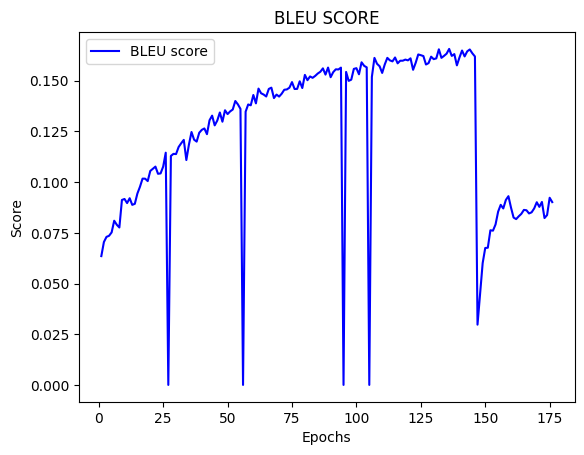

In [46]:
# 訓練模型
for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    bleu_scores = []

    start_time = time.time()
    train_loss = train(path='./MODELS/translation_model({}).pth'.format(model_name))
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch {epoch+1:02} | Train Time: {epoch_mins}m {epoch_secs}s')

    start_time = time.time()
    test_loss = evaluate()

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Test Time: {epoch_mins}m {epoch_secs}s')

    start_time = time.time()
    score = bleu_score(test_source_sentences,model,max_length,device)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Eval Time: {epoch_mins}m {epoch_secs}s')

    # 儲存訓練好的模型
    if(test_score['avg'] > best_score or test_loss < best_loss):
       if(test_loss < best_loss):
          best_loss = test_loss
       if(test_score['avg'] > best_score):
          best_score = test_score['avg']
       torch.save(model.state_dict(), './MODELS/best_translation_model({}).pth'.format(model_name))
       print('== save model ==')
        
    print('\tTrain Loss: {:.3f} | Test Loss: {:.3f}'.format(train_loss, test_loss))
    print('\tBLEU Score: {:.3f}'.format(score))

    if(best_score - test_score['avg'] > 3 or test_score['avg'] < 0.01):
      try:
        model.load_state_dict(torch.load('./MODELS/best_translation_model({}).pth'.format(model_name)))
        print('-'*5,'load_best_model','-'*5)
      except:
        model = TranslationModel(my_model).to(device)
        print('-'*5,'initialize','-'*5)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    bleu_scores.append(score)

    loss_history(train_losses, test_losses, path=model_name, to_show=False)
    bleu_history(bleu_scores, path=model_name, to_show=False)

In [ ]:
bleu_score(test_source_sentences,model,max_length,device)

In [57]:
from sacrebleu.metrics import BLEU
from tqdm import tqdm
import numpy as np

def analysis_score(s_list,title):
# 平均
  mean = np.mean(s_list)
# 方差
  var = np.var(s_list,ddof=1)
# 標準差
  std = np.std(s_list,ddof=1)
  print('==',title,'==')
  print('Mean:',mean)
  print('Var:',var)
  print('Std:',std)
    
def sacrebleu_score(model, source_sentences,target_sentences,lang='ko',output_generated=False):
  global my_tokenizer, tgt_tokenizer, max_length, device
  bleu = BLEU()
  bleu.trg_lang = lang
  avg_score = {'avg':[],'1-gram':[],'2-gram':[],'3-gram':[],'4-gram':[]}

  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(source_sentences)) as pbar:
    for i in range(len(source_sentences)):
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]
        source_tokens = my_src_tokenizer(source_sentence, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
        with torch.no_grad():
            output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
        generated_sentence = my_tgt_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
        gen_sent = ''
        for sent in generated_sentence:
            gen_sent += sent 
        bleu_score = bleu.corpus_score([gen_sent],[[target_sentence]])
        #print([gen_sent],[[target_sentence]])
        #print(bleu_score)
        avg_score['avg'].append(bleu_score.score)     
        avg_score['1-gram'].append(bleu_score.precisions[0])      
        avg_score['2-gram'].append(bleu_score.precisions[1])
        avg_score['3-gram'].append(bleu_score.precisions[2])
        avg_score['4-gram'].append(bleu_score.precisions[3])
        pbar.update(1)

  analysis_score(avg_score['avg'],title='avg')
  analysis_score(avg_score['1-gram'],title='1-gram')
  analysis_score(avg_score['2-gram'],title='2-gram')
  analysis_score(avg_score['3-gram'],title='3-gram')
  analysis_score(avg_score['4-gram'],title='4-gram')
  if(output_generated):
        avg_score['output'] = generated_sentences
  #print('gen:',generated_sentences,'tar:',[[sent] for sent in target_sentences],'sor',source_sentences)
  #print('BLEU Score:',bleu.score)

  return avg_score

In [91]:
my_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [100]:
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased').to(device)
my_model = TranslationModel(bert_model).to(device)
my_model.load_state_dict(torch.load('./MODELS/best_translation_model(ZK1).pth'))

<All keys matched successfully>

In [92]:
my_src_tokenizer = my_tokenizer
my_tgt_tokenizer = my_tokenizer

In [102]:
# best_translation_model(ZK1).pth
train_score = sacrebleu_score(TRAIN_ZSENT,TRAIN_KSENT)
test_score = sacrebleu_score(TEST_ZSENT,TEST_KSENT)
print('Train:',train_score)
print('Test:',test_score)

100%|████████████████████████████████████████████████████████████████████████████| 36089/36089 [03:23<00:00, 177.01it/s]

Train: {'avg': 9.709350444946514, '1-gram': 33.360631680660404, '2-gram': 15.469886176828068, '3-gram': 9.667330497100153, '4-gram': 6.171469824361048}
Test: {'avg': 3.4195701996118903, '1-gram': 13.467277849894918, '2-gram': 6.178931352084021, '3-gram': 3.8111523642879237, '4-gram': 2.4110431605218654}


In [80]:
# best_translation_model(ZK3_zh).pth
train_score = sacrebleu_score(TRAIN_ZSENT,TRAIN_KSENT)
test_score = sacrebleu_score(TEST_ZSENT,TEST_KSENT)
print('Train:',train_score)
print('Test:',test_score)

100%|████████████████████████████████████████████████████████████████████████████| 36089/36089 [03:00<00:00, 200.26it/s]

Train: {'avg': 74.83872064302761, '1-gram': 90.2927690452662, '2-gram': 82.99562640895392, '3-gram': 75.81112091088643, '4-gram': 69.551313764024}
Test: {'avg': 8.843460114389497, '1-gram': 20.370982428338017, '2-gram': 12.215845936874512, '3-gram': 8.871147299464774, '4-gram': 7.092441168170394}


In [13]:
my_model = TranslationModel(ko_bert_model).to(device)
my_model.load_state_dict(torch.load('./MODELS/best_translation_model(ZK4_ko).pth'))

<All keys matched successfully>

In [113]:
my_src_tokenizer = zh_tokenizer
my_tgt_tokenizer = ko_tokenizer

In [19]:
# best_translation_model(ZK4_ko).pth
train_score = sacrebleu_score(TRAIN_ZSENT,TRAIN_KSENT)
test_score = sacrebleu_score(TEST_ZSENT,TEST_KSENT)
print('Train:',train_score)
print('Test:',test_score)

100%|████████████████████████████████████████████████████████████████████████████| 36089/36089 [02:56<00:00, 204.11it/s]

Train: {'avg': 4.448467810038764, '1-gram': 18.770164983355215, '2-gram': 8.287575121838216, '3-gram': 4.720254500100213, '4-gram': 3.00352296229418}
Test: {'avg': 3.956485526995676, '1-gram': 17.643038175506973, '2-gram': 7.946271680784469, '3-gram': 4.462849241223479, '4-gram': 2.8052166087668273}


In [47]:
import numpy as np
def analysis_score(s_list):
# 平均
  mean = np.mean(s_list)
# 方差
  var = np.var(s_list,ddof=1)
# 標準差
  std = np.std(s_list,ddof=1)
  print('Mean:',mean)
  print('Var:',var)
  print('Std:',std)

In [26]:
# ted tlaks
# bleu score for 10 times
scores = []
for i in range(10):
  start_time = time.time()

  samples = get_samples(TEST_ZSENT,TEST_KSENT,p=0.2)
  test_score = sacrebleu_score(model, source_sentences=samples['zh'],target_sentences=samples['ko'])
  #test_score = sacrebleu_score(model, source_sentences=TEST_ZSENT,target_sentences=TEST_KSENT)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Eval Time: {epoch_mins}m {epoch_secs}s')
    
  #print('\tBLEU Score:')
  #for k in test_score.keys():
  #  print('\t\t{}: {:.3f}'.format(k,test_score[k]))

  scores.append(test_score['avg'])


100%|███████████████████████████████████████| 7217/7217 [03:22<00:00, 35.69it/s]


== avg ==
Mean: 8.824481812914241
Var: 424.00169389000837
Std: 20.591301413218357
== 1-gram ==
Mean: 20.2311407315512
Var: 586.3463063238165
Std: 24.214588708541314
== 2-gram ==
Mean: 12.064145954313334
Var: 524.9948041797877
Std: 22.912765092406193
== 3-gram ==
Mean: 8.827393198561444
Var: 433.6560197361103
Std: 20.82440922898199
== 4-gram ==
Mean: 7.032518853402078
Var: 392.9835770940061
Std: 19.823813384261012
Eval Time: 3m 22s


100%|███████████████████████████████████████| 7217/7217 [03:21<00:00, 35.84it/s]


== avg ==
Mean: 8.709064123294098
Var: 419.3919390511946
Std: 20.479060990465225
== 1-gram ==
Mean: 20.282855256628892
Var: 587.2820554755111
Std: 24.23390301778711
== 2-gram ==
Mean: 12.049314352849567
Var: 523.145722945327
Std: 22.872379039910278
== 3-gram ==
Mean: 8.78430991554557
Var: 431.12745958150396
Std: 20.7636090211096
== 4-gram ==
Mean: 6.955040205386134
Var: 391.20616927530455
Std: 19.77893246045662
Eval Time: 3m 21s


100%|███████████████████████████████████████| 7217/7217 [03:21<00:00, 35.81it/s]


== avg ==
Mean: 8.926264577574345
Var: 427.36550152053576
Std: 20.672820357187256
== 1-gram ==
Mean: 20.575578863162033
Var: 609.1143548256739
Std: 24.680242195441963
== 2-gram ==
Mean: 12.426100672698256
Var: 543.7802325638753
Std: 23.319095877925356
== 3-gram ==
Mean: 8.901471672879934
Var: 433.66359784907917
Std: 20.82459118083904
== 4-gram ==
Mean: 7.082822111222268
Var: 396.69771176799054
Std: 19.917271694888097
Eval Time: 3m 21s


100%|███████████████████████████████████████| 7217/7217 [03:21<00:00, 35.75it/s]


== avg ==
Mean: 8.609405197937274
Var: 410.3211264765718
Std: 20.256384832357718
== 1-gram ==
Mean: 20.327357593653048
Var: 580.3322881557301
Std: 24.090086927110292
== 2-gram ==
Mean: 12.102135692320015
Var: 524.2332780879179
Std: 22.896141117837256
== 3-gram ==
Mean: 8.599634397456661
Var: 416.36704707831444
Std: 20.405074052262453
== 4-gram ==
Mean: 6.820955180274633
Var: 383.48677816526674
Std: 19.582818442840825
Eval Time: 3m 21s


100%|███████████████████████████████████████| 7217/7217 [03:21<00:00, 35.79it/s]


== avg ==
Mean: 8.43226753077729
Var: 396.39829752600895
Std: 19.90975382886511
== 1-gram ==
Mean: 19.9170057572409
Var: 565.5339313675828
Std: 23.780957326558212
== 2-gram ==
Mean: 11.820706619497189
Var: 504.26007562235765
Std: 22.455735918075757
== 3-gram ==
Mean: 8.373889468161039
Var: 398.45960564753216
Std: 19.96145299439728
== 4-gram ==
Mean: 6.625191657898031
Var: 364.99802911697134
Std: 19.10492159410688
Eval Time: 3m 21s


100%|███████████████████████████████████████| 7217/7217 [03:21<00:00, 35.81it/s]


== avg ==
Mean: 8.65675050752822
Var: 414.12261726273914
Std: 20.35000288114818
== 1-gram ==
Mean: 19.952912612660032
Var: 566.2989131390276
Std: 23.79703580572647
== 2-gram ==
Mean: 11.772222780119147
Var: 504.46119451646416
Std: 22.46021359017906
== 3-gram ==
Mean: 8.560524448631027
Var: 418.066804286011
Std: 20.446681987207874
== 4-gram ==
Mean: 6.861019135938289
Var: 387.0618069740257
Std: 19.67388642271846
Eval Time: 3m 21s


100%|███████████████████████████████████████| 7217/7217 [03:21<00:00, 35.76it/s]


== avg ==
Mean: 8.640520440136436
Var: 412.5673884835872
Std: 20.31175493362371
== 1-gram ==
Mean: 20.083832135539875
Var: 572.3582814995157
Std: 23.924010564692445
== 2-gram ==
Mean: 11.891026891365113
Var: 515.7602156519179
Std: 22.710354811229124
== 3-gram ==
Mean: 8.561747009735793
Var: 418.93778092245196
Std: 20.46796963361173
== 4-gram ==
Mean: 6.852220219139785
Var: 383.24764737307396
Std: 19.57671186315705
Eval Time: 3m 21s


100%|███████████████████████████████████████| 7217/7217 [03:21<00:00, 35.77it/s]


== avg ==
Mean: 8.927423963038573
Var: 430.68699952855184
Std: 20.752999771805325
== 1-gram ==
Mean: 20.47946154078228
Var: 601.417790117395
Std: 24.523820871091743
== 2-gram ==
Mean: 12.403418487145448
Var: 543.0521254679753
Std: 23.303478827590855
== 3-gram ==
Mean: 8.89949164648379
Var: 433.72574322525037
Std: 20.82608324254108
== 4-gram ==
Mean: 7.0907086079324175
Var: 396.7246143954404
Std: 19.917947042690933
Eval Time: 3m 21s


100%|███████████████████████████████████████| 7217/7217 [03:21<00:00, 35.83it/s]


== avg ==
Mean: 8.746225146913304
Var: 421.4385411705797
Std: 20.52896834160401
== 1-gram ==
Mean: 20.16927380821216
Var: 589.2278179445906
Std: 24.274015282696652
== 2-gram ==
Mean: 12.124028756468283
Var: 530.6914572092554
Std: 23.036741462482393
== 3-gram ==
Mean: 8.679800102037847
Var: 425.25106415770017
Std: 20.621616429312716
== 4-gram ==
Mean: 6.960096359525867
Var: 392.9947530536136
Std: 19.824095264440533
Eval Time: 3m 21s


100%|███████████████████████████████████████| 7217/7217 [03:21<00:00, 35.79it/s]


== avg ==
Mean: 8.631629992471797
Var: 402.35190528627777
Std: 20.058711456279482
== 1-gram ==
Mean: 20.312542447425812
Var: 584.4272980068986
Std: 24.17493118928984
== 2-gram ==
Mean: 12.060331758682016
Var: 515.48012562164
Std: 22.704187402803914
== 3-gram ==
Mean: 8.615162745593576
Var: 409.34454811174487
Std: 20.232265026727603
== 4-gram ==
Mean: 6.78635019219025
Var: 368.4505675661025
Std: 19.195066229792033
Eval Time: 3m 21s


In [27]:
print('ted talks:')
analysis_score(scores,'') # ted talks

ted talks:
==  ==
Mean: 8.710403329258558
Var: 0.02328006194711342
Std: 0.15257805198361074


8.710403329258558

In [33]:
scores_2 = []
for i in range(10):
  start_time = time.time()
  print('='*20)
  print('case',i)

  
  samples = get_samples(TEST_ZSENT,TEST_KSENT,p=0.2)
  test_score = sacrebleu_score(model, source_sentences=samples['zh'],target_sentences=samples['ko'])
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Eval Time: {epoch_mins}m {epoch_secs}s')
#  print('\tBLEU Score:')
#  for k in test_score.keys():
#    print('\t\t{}: {:.3f}'.format(k,test_score[k]))

  scores_2.append(test_score['avg'])


case 0


100%|█████████████████████████████████████| 15568/15568 [06:49<00:00, 38.04it/s]


== avg ==
Mean: 4.616470794594415
Var: 30.46674595321536
Std: 5.519669007577842
== 1-gram ==
Mean: 20.166224772896527
Var: 255.35913203584093
Std: 15.97996032647894
== 2-gram ==
Mean: 7.844153547558673
Var: 157.97543319694444
Std: 12.568827837031758
== 3-gram ==
Mean: 4.582093983525801
Var: 87.01930632312454
Std: 9.328413923230709
== 4-gram ==
Mean: 2.4374499145986563
Var: 21.816834788188388
Std: 4.670849471797222
Eval Time: 6m 49s
case 1


100%|█████████████████████████████████████| 15568/15568 [07:14<00:00, 35.85it/s]


== avg ==
Mean: 4.565381788450855
Var: 31.210622616645587
Std: 5.5866468133081035
== 1-gram ==
Mean: 20.13145754814628
Var: 260.55605981852864
Std: 16.141748970248813
== 2-gram ==
Mean: 7.833690252525954
Var: 163.91345326406824
Std: 12.802868946609905
== 3-gram ==
Mean: 4.527181199988704
Var: 86.424411821428
Std: 9.296473085069843
== 4-gram ==
Mean: 2.4510231087915124
Var: 24.25214969252518
Std: 4.9246471642672205
Eval Time: 7m 14s
case 2


100%|█████████████████████████████████████| 15568/15568 [07:13<00:00, 35.93it/s]


== avg ==
Mean: 4.607986699833341
Var: 29.894608617521996
Std: 5.4675962376095395
== 1-gram ==
Mean: 20.2312698500635
Var: 259.11303283573045
Std: 16.09698831569839
== 2-gram ==
Mean: 7.884065877843721
Var: 164.28597322159965
Std: 12.81740899018205
== 3-gram ==
Mean: 4.623223431006607
Var: 93.0603655341397
Std: 9.646780060421182
== 4-gram ==
Mean: 2.428205378593803
Var: 22.013753988660113
Std: 4.691881710855476
Eval Time: 7m 13s
case 3


100%|█████████████████████████████████████| 15568/15568 [07:14<00:00, 35.85it/s]


== avg ==
Mean: 4.7237738304055
Var: 34.39790963377008
Std: 5.864973114496782
== 1-gram ==
Mean: 20.25896151172566
Var: 258.93282336025294
Std: 16.091389727436624
== 2-gram ==
Mean: 7.89109381167891
Var: 156.8960725053704
Std: 12.525816241082671
== 3-gram ==
Mean: 4.763448924329756
Var: 97.90391907738365
Std: 9.894640927157672
== 4-gram ==
Mean: 2.53773388908554
Var: 25.786932414776484
Std: 5.078083537593339
Eval Time: 7m 14s
case 4


100%|█████████████████████████████████████| 15568/15568 [07:13<00:00, 35.87it/s]


== avg ==
Mean: 4.602765154839934
Var: 29.724751494788354
Std: 5.45204103935291
== 1-gram ==
Mean: 20.15368054288483
Var: 260.716300208875
Std: 16.146711746014265
== 2-gram ==
Mean: 7.927220990763594
Var: 165.22963150962445
Std: 12.854167865312187
== 3-gram ==
Mean: 4.696523418642593
Var: 96.66570346355132
Std: 9.831871818913799
== 4-gram ==
Mean: 2.4473522167338095
Var: 22.104693862737136
Std: 4.701562917024203
Eval Time: 7m 13s
case 5


100%|█████████████████████████████████████| 15568/15568 [07:14<00:00, 35.81it/s]


== avg ==
Mean: 4.567025908652382
Var: 27.103668246919383
Std: 5.206118347379301
== 1-gram ==
Mean: 20.123585427164674
Var: 251.33435153562974
Std: 15.85352804695629
== 2-gram ==
Mean: 7.722493406273079
Var: 151.32918223993534
Std: 12.30159267086727
== 3-gram ==
Mean: 4.605830100631104
Var: 89.70388427594534
Std: 9.471213453193068
== 4-gram ==
Mean: 2.415817165820393
Var: 18.941242077104643
Std: 4.352153728569872
Eval Time: 7m 14s
case 6


100%|█████████████████████████████████████| 15568/15568 [07:14<00:00, 35.79it/s]


== avg ==
Mean: 4.540161444758198
Var: 25.236030621026874
Std: 5.0235476130944425
== 1-gram ==
Mean: 19.932383548279848
Var: 238.31731572458332
Std: 15.437529456638563
== 2-gram ==
Mean: 7.643814272301944
Var: 143.6794716793204
Std: 11.986637213135316
== 3-gram ==
Mean: 4.542063091270354
Var: 84.29582221308092
Std: 9.181275631037385
== 4-gram ==
Mean: 2.387535925190392
Var: 16.965626457502303
Std: 4.118935112077186
Eval Time: 7m 15s
case 7


100%|█████████████████████████████████████| 15568/15568 [06:00<00:00, 43.16it/s]


== avg ==
Mean: 4.590554154069834
Var: 30.237508090560887
Std: 5.498864254603935
== 1-gram ==
Mean: 20.115165219839245
Var: 258.023471721675
Std: 16.06310903037376
== 2-gram ==
Mean: 7.795298879821405
Var: 157.85166613419554
Std: 12.563903300097289
== 3-gram ==
Mean: 4.578266160446019
Var: 88.99611491031733
Std: 9.433775220468068
== 4-gram ==
Mean: 2.4352613573950945
Var: 21.566848172569458
Std: 4.644012077134324
Eval Time: 6m 0s
case 8


100%|█████████████████████████████████████| 15568/15568 [04:53<00:00, 53.00it/s]


== avg ==
Mean: 4.563086888720021
Var: 25.211192572988637
Std: 5.021074842400642
== 1-gram ==
Mean: 20.080979370090734
Var: 255.41442500189095
Std: 15.98169030490489
== 2-gram ==
Mean: 7.866007698905684
Var: 161.80402041979215
Std: 12.720220926532376
== 3-gram ==
Mean: 4.545683233552077
Var: 83.25601350904252
Std: 9.12447332776213
== 4-gram ==
Mean: 2.4110251943015037
Var: 16.61698345794985
Std: 4.07639343758056
Eval Time: 4m 53s
case 9


100%|█████████████████████████████████████| 15568/15568 [07:14<00:00, 35.79it/s]

== avg ==
Mean: 4.592641669676345
Var: 28.949735632278134
Std: 5.380495853755315
== 1-gram ==
Mean: 20.010526098837985
Var: 256.6952348596072
Std: 16.021711358641035
== 2-gram ==
Mean: 7.8172450618182925
Var: 158.84883966959435
Std: 12.603524890664293
== 3-gram ==
Mean: 4.611502489884593
Var: 90.2530869452936
Std: 9.500162469415647
== 4-gram ==
Mean: 2.445886182020331
Var: 21.11230678027617
Std: 4.594813029958474
Eval Time: 7m 14s


In [34]:
print('\nted2020:')
analysis_score(scores_2,'') # ted2020



ted2020:
==  ==
Mean: 4.596984833400083
Var: 0.0025493422340478068
Std: 0.05049101141834858


4.596984833400083